# Advanced Tutorial 6: Summary

## Overview
In this tutorial, we will discuss the following topics:
* Experiment Logging
* Experiment Summaries
* Log Parsing
* Summary Visualization
* TensorBoard Visualization

## Preliminary Setup

We will first set up a basic MNIST example for the rest of the demonstrations:

In [1]:
import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.schedule import cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.metric import Accuracy
from fastestimator.trace.io import TensorBoard

train_data, eval_data = mnist.load_data()
test_data = eval_data.split(0.5)
pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       batch_size=32,
                       ops=[ExpandDims(inputs="x", outputs="x"), Minmax(inputs="x", outputs="x")])

model = fe.build(model_fn=LeNet, optimizer_fn="adam")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
    UpdateOp(model=model, loss_name="ce")
])

traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    LRScheduler(model=model, lr_fn=lambda step: cosine_decay(step, cycle_length=3750, init_lr=1e-3))
]

## Experiment Logging

As you may have noticed if you have used FastEstimator, log messages are printed to the screen during training. If you want to persist these log messages for later records, you can simply pipe them into a file when launching training from the command line, or else just copy and paste the messages from the console into a persistent file on the disk. FastEstimator allows logging to be controlled via arguments passed to the `Estimator` class. Let's see some examples of this: 

In [2]:
est = fe.Estimator(pipeline=pipeline, network=network, epochs=1, traces=traces)
est.fit()

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; model_lr: 0.001; 
FastEstimator-Train: step: 1; ce: 2.2841144; model_lr: 0.001; 
FastEstimator-Train: step: 100; ce: 0.2376824; steps/sec: 148.94; model_lr: 0.000998283; 
FastEstimator-Train: step: 200; ce: 0.32915652; steps/sec: 148.35; model_lr: 0.0009930746; 
FastEstimator-Train: step: 300; ce: 0.074138686; steps/sec: 143.59; model_lr: 0.0009844112; 
FastEstimator-Train: step: 400; ce: 0.31574142; steps/sec: 130.72; model_lr: 0.00097235345; 
FastEs

As you can see, the default behavior prints logs every 100 steps. Let's suppose this was too much logging and you instead wanted a message only once every 500 steps:

In [3]:
est = fe.Estimator(pipeline=pipeline, network=network, epochs=1, traces=traces, log_steps=500)
est.fit()

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; model_lr: 0.0005009185; 
FastEstimator-Train: step: 1; ce: 0.0040256567; model_lr: 0.001; 
FastEstimator-Train: step: 500; ce: 0.011354227; steps/sec: 165.96; model_lr: 0.000956986; 
FastEstimator-Train: step: 1000; ce: 0.052720923; steps/sec: 172.19; model_lr: 0.0008350416; 
FastEstimator-Train: step: 1500; ce: 0.19931549; steps/sec: 167.62; model_lr: 0.0006552519; 
FastEstimator-Train: step: 1875; epoch: 1; epoch_time: 11.39 sec; 
FastEstimator-Eval

Let's suppose that this is still too much logging, and you want to entirely disable the step level logging and only see epoch related messages:

In [4]:
est = fe.Estimator(pipeline=pipeline, network=network, epochs=1, traces=traces, log_steps=0)
est.fit()

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; model_lr: 0.0005009185; 
FastEstimator-Eval: step: 1875; epoch: 1; ce: 0.024060594; min_ce: 0.024060594; since_best: 0; accuracy: 0.9922; 
FastEstimator-Finish: step: 1875; total_time: 11.89 sec; model_lr: 0.0005009185; 


But what if this is still too much logging? Log printing during the training loop can also be disabled entirely:

In [5]:
est = fe.Estimator(pipeline=pipeline, network=network, epochs=1, traces=traces, log_steps=None)
est.fit()

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



## Experiment Summaries

Having log messages on the screen can be handy, but what if you want to access these messages within python? Enter the `Summary` class. `Summary` objects contain information about the training over time, and will be automatically generated when the `Estimator` fit() method is invoked with an experiment name: 

In [6]:
est = fe.Estimator(pipeline=pipeline, network=network, epochs=1, traces=traces, log_steps=500)
summary = est.fit("experiment1")

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; model_lr: 0.0005009185; 
FastEstimator-Train: step: 1; ce: 0.010224803; model_lr: 0.001; 
FastEstimator-Train: step: 500; ce: 0.00044568052; steps/sec: 168.36; model_lr: 0.000956986; 
FastEstimator-Train: step: 1000; ce: 0.0037907017; steps/sec: 170.3; model_lr: 0.0008350416; 
FastEstimator-Train: step: 1500; ce: 0.0023785874; steps/sec: 169.43; model_lr: 0.0006552519; 
FastEstimator-Train: step: 1875; epoch: 1; epoch_time: 11.18 sec; 
FastEstimator-E

Lets take a look at what sort of information is contained within our `Summary` object:

In [7]:
summary.name

'experiment1'

In [8]:
summary.history

defaultdict(<function fastestimator.summary.summary.Summary.__init__.<locals>.<lambda>()>,
            {'train': defaultdict(dict,
                         {'model_lr': {0: array(0.00050092, dtype=float32),
                           1: array(0.001, dtype=float32),
                           500: array(0.00095699, dtype=float32),
                           1000: array(0.00083504, dtype=float32),
                           1500: array(0.00065525, dtype=float32)},
                          'ce': {1: array(0.0102248, dtype=float32),
                           500: array(0.00044568, dtype=float32),
                           1000: array(0.0037907, dtype=float32),
                           1500: array(0.00237859, dtype=float32)},
                          'steps/sec': {500: array(168.36),
                           1000: array(170.3),
                           1500: array(169.43)},
                          'epoch': {1875: 1},
                          'epoch_time': {1875: array('11.18 se

The history field can appear a little daunting, but it is simply a dictionary laid out as follows: {mode: {key: {step: value}}}. Once you have invoked the .fit() method with an experiment name, subsequent calls to .test() will add their results into the same summary dictionary:

In [9]:
summary = est.test()

FastEstimator-Test: epoch: 1; accuracy: 0.9918; 


In [10]:
summary.history

defaultdict(<function fastestimator.summary.summary.Summary.__init__.<locals>.<lambda>()>,
            {'train': defaultdict(dict,
                         {'model_lr': {0: array(0.00050092, dtype=float32),
                           1: array(0.001, dtype=float32),
                           500: array(0.00095699, dtype=float32),
                           1000: array(0.00083504, dtype=float32),
                           1500: array(0.00065525, dtype=float32)},
                          'ce': {1: array(0.0102248, dtype=float32),
                           500: array(0.00044568, dtype=float32),
                           1000: array(0.0037907, dtype=float32),
                           1500: array(0.00237859, dtype=float32)},
                          'steps/sec': {500: array(168.36),
                           1000: array(170.3),
                           1500: array(169.43)},
                          'epoch': {1875: 1},
                          'epoch_time': {1875: array('11.18 se

Even if an experiment name was not provided during the .fit() call, it may be provided during the .test() call. The resulting summary object will, however, only contain information from the Test mode.

## Log Parsing

Suppose that you have a log file saved to disk, and you want to create an in-memory `Summary` representation of it. This can be done through FastEstimator logging utilities:

In [11]:
summary = fe.summary.logs.parse_log_file(file_path="../resources/t06a_exp1.txt", file_extension=".txt")

In [12]:
summary.name

't06a_exp1'

In [13]:
summary.history['eval']

defaultdict(dict,
            {'epoch': {1875: 1.0, 3750: 2.0, 5625: 3.0},
             'ce': {1875: 0.03284014, 3750: 0.02343675, 5625: 0.02382297},
             'min_ce': {1875: 0.03284014, 3750: 0.02343675, 5625: 0.02343675},
             'since_best': {1875: 0.0, 3750: 0.0, 5625: 1.0},
             'accuracy': {1875: 0.9882, 3750: 0.992, 5625: 0.9922}})

## Log Visualization

While seeing log data as numbers can be informative, visualizations of data are often more useful. FastEstimator provides several ways to visualize log data: from python using `Summary` objects or log files, as well as through the command line. 

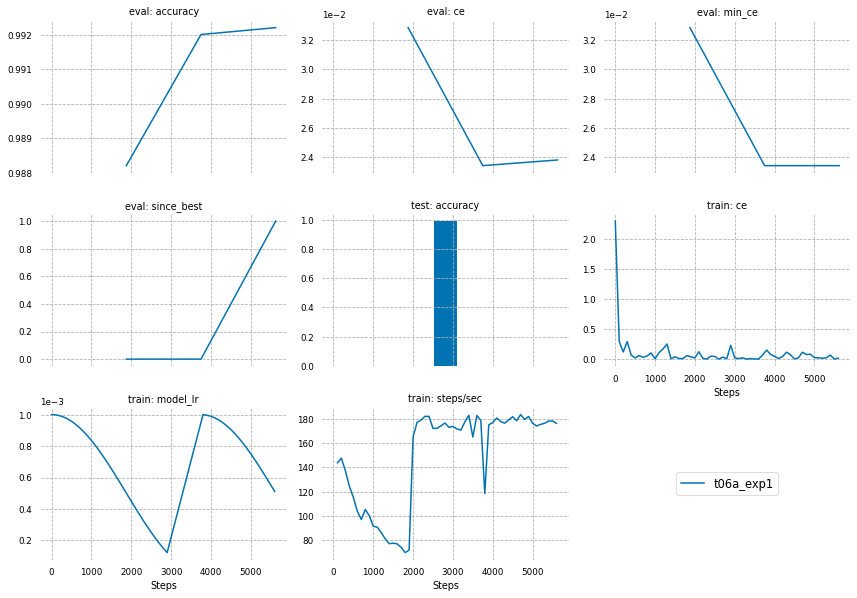

In [14]:
fe.summary.logs.visualize_logs(experiments=[summary])

If you are only interested in visualizing a subset of these log values, it is also possible to whitelist or blacklist values via the 'include_metrics' and 'ignore_metrics' arguments respectively:

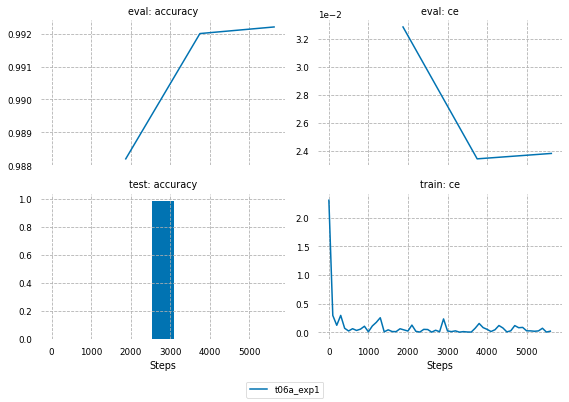

In [15]:
fe.summary.logs.visualize_logs(experiments=[summary], include_metrics={"accuracy", "ce"})

It is also possible to compare logs from different experiments, which can be especially useful when fiddling with hyper-parameter values to determine their effects on training:

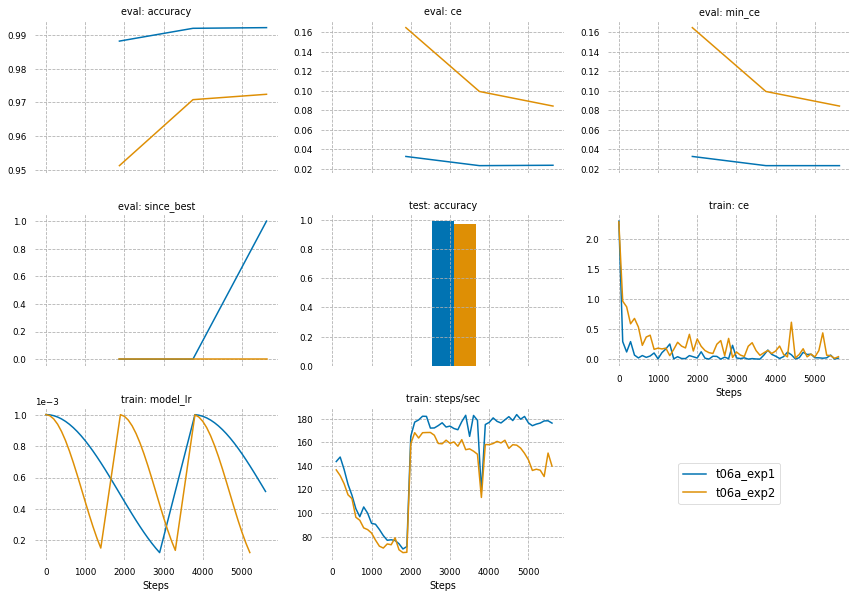

In [16]:
fe.summary.logs.parse_log_files(file_paths=["../resources/t06a_exp1.txt", "../resources/t06a_exp2.txt"], log_extension=".txt")

All of the log files within a given directory can also be compared at the same time, either by using the parse_log_dir() method or via the command line as follows: fastestimator logs --extension .txt --smooth 0 ../resources

## TensorBoard

Of course, no modern AI framework would be complete without TensorBoard integration. In FastEstimator, all that is required to achieve TensorBoard integration is to add the TensorBoard `Trace` to the list of traces passed to the `Estimator`:

In [17]:
pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       batch_size=32,
                       ops=[ExpandDims(inputs="x", outputs="x"), Minmax(inputs="x", outputs="x")], num_process=0)
model = fe.build(model_fn=LeNet, optimizer_fn="adam")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
    UpdateOp(model=model, loss_name="ce")
])
traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    LRScheduler(model=model, lr_fn=lambda step: cosine_decay(step, cycle_length=3750, init_lr=1e-3)),
    TensorBoard(log_dir="../outputs/t06a_tboard", weight_histogram_freq="epoch")
]
est = fe.Estimator(pipeline=pipeline, network=network, epochs=3, traces=traces, log_steps=1000)
est.fit()

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Tensorboard: writing logs to /Users/skynet/Development/fastestimator/tutorial/outputs/t06a_tboard/20200423-153828
FastEstimator-Start: step: 1; model1_lr: 0.001; 
FastEstimator-Train: step: 1; ce: 2.3131576; model1_lr: 0.001; 
FastEstimator-Train: step: 1000; ce: 0.20151168; steps/sec: 68.63; model1_lr: 0.0008350416; 
FastEstimator-Train: step: 1875; epoch: 1; epoch_time: 27.6 sec; 
FastEstimator-Eval: step: 1875; epoch: 1; ce: 0.037083723; min_ce: 0.037083723; since

Now let's launch TensorBoard to visualize our logs. Note that this call will prevent any subsequent Jupyter Notebook cells from running until you manually terminate it.

In [18]:
!tensorboard --reload_multifile=true --logdir ../outputs/t06a_tboard

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C
